## Libraries

In [33]:
import os
import ast
import pandas as pd
import numpy as np
import glob
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Loading Data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class ModelDataLoader():
    '''Loads and provides access to model input data and related information'''
    def __init__(self, version='005'):
        # Use the specific path for the data
        self.data_path = f'/content/drive/MyDrive/model_input_{version}'
        self.df = self.get_df_from_parquet()
        self.feature_names = [
            'spectral_centroids_mean',
            'spectral_centroids_delta_mean',
            'spectral_centroids_accelerate_mean',
            'spectral_bandwidth_mean',
            'spectral_rolloff_mean',
            'zero_crossing_rate_mean',
            'rms_mean',
            'chroma_stft_mean',
            'mfccs_mean',
            'onset',
            'tempo',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max'
        ]
        self.label_names = self.df.label.unique()
        self.class_distribution = pd.DataFrame(self.df['label'].value_counts(normalize=True) * 100).reset_index()

        self.add_named_feature_columns()

    def test_row_uniqueness(self, model_data_loader_df):
        '''Asserts that there are no duplicate rows in the provided dataframe'''
        try:
            assert len(
                set(
                    (len(model_data_loader_df),
                     len(pd.Series(model_data_loader_df.index).value_counts()),
                     len(model_data_loader_df.groupby('track_id').count()),
                     len(model_data_loader_df.groupby('audio_path').count()))
                )
            ) == 1, 'ERROR: Incorrect Row-Wise Structure of DataFrame, there are duplicate indexes or audio files'
        except AssertionError as msg:
            print(msg)

    def get_df_from_parquet(self):
        '''Reads dataframe from parquet, drops unneeded columns, resets index'''
        df = pd.read_parquet(self.data_path)
        drop_columns = [column for column in df.columns if column in ['level_0', 'index']]
        df.drop(columns=drop_columns, inplace=True, errors='ignore')
        df.reset_index(drop=True, inplace=True)
        # Test for row uniqueness
        self.test_row_uniqueness(df)
        return df

    def add_named_feature_columns(self):
        for index, feature in enumerate(self.feature_names):
            self.df[feature] = self.df.features.map(lambda features: features[index] if features is not None else None)

    def get_mfcc(self):
        npy_path = self.data_path + '_mfcc/*npy'
        files = glob.glob(npy_path)
        mfcc_array = []
        for file in files:
            mfcc_array.append(np.load(file, allow_pickle=True))
        # Combine all loaded MFCC arrays
        combined_array = np.concatenate(mfcc_array, axis=0)
        return combined_array


In [11]:
# Initialize ModelDataLoader with the correct directory path
model_data_loader = ModelDataLoader(version='005')

# Access the loaded DataFrame
df = model_data_loader.df
print("DataFrame loaded:")
display(df.head())

DataFrame loaded:


,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,features,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
0,000002,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,"[3683.9976, 1.2325847, -0.45687142, 3495.6704,...",...,0.098364,0.141225,0.424169,-1.742610,1.403928,166.708664,21.300203,0.022087,-505.499176,196.868652
1,000005,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,"[2928.3987, 0.68091094, 0.02261393, 3383.929, ...",...,0.059334,0.145243,0.475249,1.318397,1.384270,99.384018,21.096722,0.005648,-528.116272,209.443054
2,000010,fma,/project_data_source/free_music_archive/fma_sm...,pop,Pop,[10],[10],1.0,44100,"[2786.7935, -0.85456085, -0.076387875, 2895.75...",...,0.080989,0.186656,0.430406,2.244156,1.123551,112.347145,20.852177,-0.033316,-537.197205,229.155151
3,000140,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,"[1957.3483, 1.3831364, 0.35159802, 2927.9644, ...",...,0.027256,0.068459,0.450882,-3.624865,1.135973,107.666016,21.727451,0.012266,-592.895813,199.950806
4,000141,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,"[1768.6066, 1.1223011, -0.09913131, 2358.3088,...",...,0.034120,0.100852,0.341356,-4.471582,0.881413,120.185318,23.654802,-0.003315,-536.546936,222.208649


## Elbow Curve

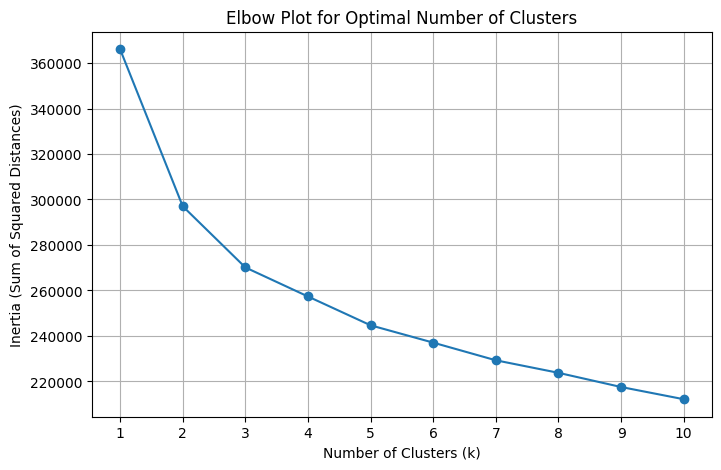

In [20]:
# Initialize the ModelDataLoader with the appropriate version
model_data_loader = ModelDataLoader(version='005')

# Extract features for clustering
features = model_data_loader.feature_names
df = model_data_loader.df
X = df[features].dropna()  # Drop rows with missing feature values

# Step 1: Preprocessing - Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Elbow Method for Optimal Clusters
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_range)
plt.grid()
plt.show()

## PCA and K Means Clustering

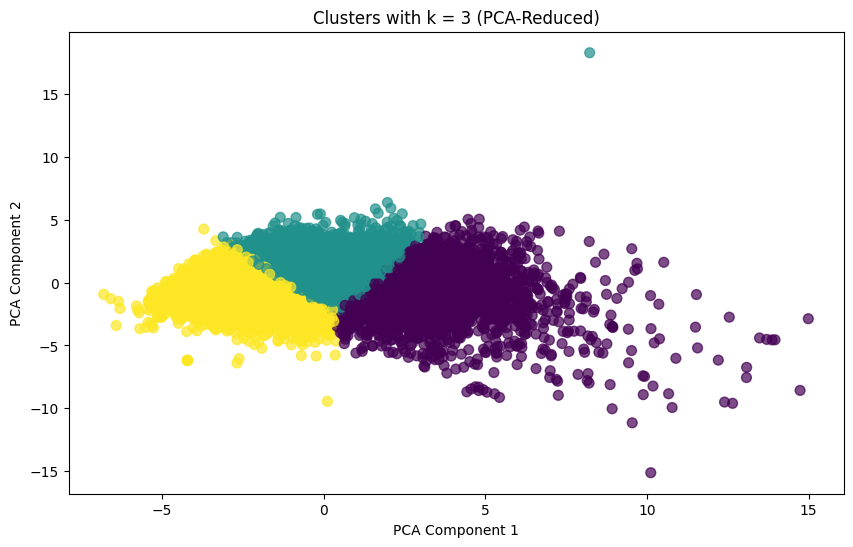

In [29]:
# Perform K-means clustering with the optimal number of clusters
optimal_clusters = 3  # Based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the clusters without centroids
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters with k = 3 (PCA-Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Add the cluster labels to the original DataFrame
df['Cluster'] = None
df.loc[X.index, 'Cluster'] = labels

In [30]:
# Evaluate clustering
silhouette_avg = silhouette_score(X_scaled, labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
davies_bouldin = davies_bouldin_score(X_scaled, labels)

# Print evaluation metrics
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

Silhouette Score: 0.1307
Calinski-Harabasz Index: 4333.7770
Davies-Bouldin Index: 2.0433


# Cluster Characteristics with Emotional Descriptions

### Cluster 0:
- **Characteristics**:
  - **Spectral Centroids Mean**: Higher (4219.82) - indicative of brighter sounds.
  - **Spectral Bandwidth Mean**: Highest (4234.71) - suggesting more harmonic complexity.
  - **Zero Crossing Rate Mean**: Higher (0.0984) - likely sharper sounds with rapid changes.
  - **MFCCs Mean**: Moderate (1.65) - suggesting a balanced tonal texture.
  - **Tempo**: ~122.66 BPM - slightly slower-paced tracks.
  - **Contrast**: Moderate (19.89) - indicating medium dynamics in the audio.
- **Emotional Description**:
  - Bright, energetic, and upbeat. Suitable for uplifting or motivating moods.

### Cluster 1:
- **Characteristics**:
  - **Spectral Centroids Mean**: Moderate (2196.20) - balanced brightness.
  - **Spectral Bandwidth Mean**: Moderate (2747.42) - indicating medium harmonic complexity.
  - **Zero Crossing Rate Mean**: Moderate (0.0467) - less sharp than Cluster 0.
  - **MFCCs Mean**: Highest (2.63) - suggesting richer tonal qualities.
  - **Tempo**: ~123.24 BPM - average tempo.
  - **Contrast**: Moderate (20.24) - slightly more dynamics than Cluster 0.
- **Emotional Description**:
  - Warm, dynamic, and balanced. Evokes a calm yet engaging mood.

### Cluster 2:
- **Characteristics**:
  - **Spectral Centroids Mean**: Lowest (1450.89) - indicative of darker, deeper sounds.
  - **Spectral Bandwidth Mean**: Lowest (1933.60) - suggesting simpler harmonic content.
  - **Zero Crossing Rate Mean**: Lowest (0.0367) - smoother sounds with fewer rapid changes.
  - **MFCCs Mean**: Lowest (-9.42) - darker tonal texture.
  - **Tempo**: ~124.28 BPM - slightly faster-paced tracks.
  - **Contrast**: Highest (21.73) - suggesting high dynamics and variability in the audio.
- **Emotional Description**:
  - Dark, introspective, and emotional. Perfect for reflective or melancholic moods.
